In [1]:
import sys
import os
import time
import pandas as pd
import pickle
import obspy
import numpy as np
import matplotlib.pyplot as plt

# Importing the main code.
module_path = os.path.abspath(os.path.join('../src/ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ocloc import ProcessingParameters, ClockDrift, suppress_stdout

In [2]:
def bootstrap_cd(cd):
    """
    Method to bootstrap the t_app values and return a new
    ClockDrift object with the bootstrapped values called
    bootstrapped_cd
    """
    bootstrapped_cd = cd.copy() # Deep copy of the cd object.
    correlations_with_tapp = []
    for c in bootstrapped_cd.correlations:
        if not np.isnan(c.t_app[-1]):
            correlations_with_tapp.append(c)
    index_list = np.random.choice(range(len(correlations_with_tapp)),
                                  replace=True,
                                  size=len(correlations_with_tapp))

    res_list = [correlations_with_tapp[i] for i in index_list]
    bootstrapped_cd.correlations = res_list
    return bootstrapped_cd

def get_a_and_b_values(cd):
    """
    Function to get a and b values when the station was included in the inversion.
    """
    a_vals = []
    b_vals = []
    stations = []
    for sta in cd.stations:
        if not sta.needs_correction:
            continue
        if sta.a[-1] == 0 and sta.b[-1] == 0:
            include = False
            for c in cd.get_correlations_of_station(sta.code):
                if not np.isnan(c.t_app[-1]):
                    include = True
                    break
            if not include:
                continue
        a_vals.append(sta.a[-1])
        b_vals.append(sta.b[-1])
        stations.append(sta.code)
    return a_vals, b_vals, stations

def perform_bootstrapping_and_solve(
        cd, min_correlation_params, days_apart, method='weighted_lstsq'):
    bootstrapped_cd = bootstrap_cd(cd)
    with suppress_stdout():
        _ = bootstrapped_cd.filter_stations(*min_correlation_params, days_apart)
        bootstrapped_cd.calculate_dt_ins()
        bootstrapped_cd.build_matrices()
        bootstrapped_cd.solve_eq(method=method)
    a_vals, b_vals, stations = get_a_and_b_values(bootstrapped_cd)
    # if any a or b value is higher than 1 then return
    if any([a > 1 for a in a_vals]) or any([b > 1 for b in b_vals]):
        return
    for station, a, b in zip(stations, a_vals, b_vals):
        # Check if station has attribute bootstrap_a and bootstrap_b
        if not hasattr(cd.get_station(station), 'bootstrap_a'):
            cd.get_station(station).bootstrap_a = []
            cd.get_station(station).bootstrap_b = []
        cd.get_station(station).bootstrap_a.append(a)
        cd.get_station(station).bootstrap_b.append(b)
        cd.get_station(station).bootstrap_inversion_method = method

def main(cd, n_iterations=100):
    min_number_of_total_correlations=3
    min_number_correlation_periods=2
    min_number_of_stationconnections=2
    days_apart=30
    min_correlation_params = [min_number_of_total_correlations, min_number_correlation_periods, min_number_of_stationconnections]
    
    for _ in range(n_iterations):
        perform_bootstrapping_and_solve(cd, min_correlation_params, days_apart)
def restart_bootstrap(cd):
    for sta in cd.stations:
        if hasattr(sta, 'bootstrap_a'):
            sta.bootstrap_a = []
        if hasattr(sta, 'bootstrap_b'):
            sta.bootstrap_b = []

def add_start_end_times_to_stations(cd, filename):
    # Read the csv file
    df = pd.read_csv(filename)

    # Iterate over each row of the DataFrame
    for idx, row in df.iterrows():
        # Find the station with the same sensor code
        try:
            station = cd.get_station(row['Sensor code'])
        except:
            print(f"Station {row['Sensor code']} not found")
            continue
        if station is not None:
            if row['Start time'] is not np.nan:
                station.start_time = obspy.UTCDateTime(row['Start time'])
                
            if row['End time'] is not np.nan:
                station.end_time = obspy.UTCDateTime(row['End time'])
            
            if row['Skew microseconds'] is not np.nan:
                station.skew_value = row['Skew microseconds']

def calculate_std(list_of_values):
    """
    Function to calculate the standard deviation of a list of values.
    """
    return np.std(list_of_values)


def calculate_drift_value(cd, station_code, time, bootstrap_a_list=[], 
                          bootstrap_b_list=[]):
    """
    Function to calculate the drift value at a given time for a given station.
    """
    station = cd.get_station(station_code)
    if station is not None:
        a = station.a[-1]
        b = station.b[-1]
        drift_value = a * (time - cd.reference_time) / 86400 + b
        if len(bootstrap_a_list) > 0 and len(bootstrap_b_list) > 0:
            bootstrapped_drift_values = np.zeros(len(bootstrap_a_list))
            for i, (a_boots, b_boots) in enumerate(zip(bootstrap_a_list, bootstrap_b_list)):
                bootstrapped_drift_values[i] = a_boots * (time - cd.reference_time) / 86400 + b_boots
            drift_std = np.std(bootstrapped_drift_values)
            _95_confidence_interval = 1.96 * drift_std / np.sqrt(len(bootstrap_a_list))
        else:
            drift_std = 0
            _95_confidence_interval = 0
        return drift_value, drift_std, _95_confidence_interval
    else:
        print(f"Station {station_code} does not exist.")
        return None, None


def create_drift_table(cd):
    rows = []
    for station in cd.stations:
        if station.needs_correction == False:
            continue
        if hasattr(station, 'bootstrap_a') is False:
            station.bootstrap_a = []
            station.bootstrap_b = []
        if hasattr(station, 'start_time') is False:
            raise ValueError(f"Station {station.code} does not have a start time.")
        start_time = station.start_time
        initial_drift, initial_drift_std, initial_drift_95 = (
            calculate_drift_value(cd, station.code, start_time, 
                                  station.bootstrap_a, station.bootstrap_b
                                  )
        )
        initial_drift_str = f"{initial_drift:2f} +/- {initial_drift_95:2f}"
        if hasattr(station, 'end_time') is False:
            end_time = "Battery died."
            final_drift_std = "Battery died."
            final_drift_str = "Battery died."
        else:
            end_time = station.end_time
            final_drift, final_drift_std, final_drift_95 = (
                calculate_drift_value(cd, station.code, end_time,
                                        station.bootstrap_a, station.bootstrap_b
                                        )
                )
            final_drift_str = f"{final_drift:2f} +/- {final_drift_95:2f}"
        if hasattr(station, 'skew_value') is False:
            skew = "No skew value provided."
            skew_leap = "No skew value provided."
        else:
            skew = -station.skew_value/1e6
            # if end_time > obspy.UTCDateTime("2015-07-01"):
            #     skew += 1 # consider the leap second
            skew_leap = skew + 1
        rows.append(
            [station.code, start_time, end_time, initial_drift_str, initial_drift_std,
             final_drift_str, final_drift_std, skew, skew_leap, 
             skew - final_drift, skew_leap-final_drift, station.a[-1], station.b[-1]])
    df = pd.DataFrame(rows, columns=[
        "Station Code", "Start Time", "End Time", "Initial Drift",
        "Initial Drift Std Dev", "Final Drift", "Final Drift Std Dev", "Skew Value", "Skew - leap second", 
        "Difference", "Difference with leap second", "Clock Drift (a)", "Drift at reference time (b)"])
    return df

def plot_drift_estimates(cd, station_code):

    station = cd.get_station(station_code)
    # plt.figure(dpi=200)
    if station is not None:
        # Generate list
        end_time = obspy.UTCDateTime("2015-09-01")
        utc_times = [obspy.UTCDateTime(x) for x in np.linspace(
            station.start_time.timestamp, end_time.timestamp, 100)]
        for boots_a, boots_b in zip(station.bootstrap_a, station.bootstrap_b):
            drifts = [boots_a * (time - cd.reference_time) / 86400 + boots_b for time in utc_times]
            t = [(x - cd.reference_time) / 86400 for x in utc_times]
            drifts = np.array(drifts)
            # plt.scatter(t, drifts, color='grey', alpha=0.5)
        upper_limit, lower_limit, mean_vals = [], [], []
        for time in utc_times:
            drift, drift_std, _95_confidence_interval = calculate_drift_value(
                cd, station_code, time, station.bootstrap_a, station.bootstrap_b)
            upper_limit.append(drift + 2 * drift_std)
            lower_limit.append(drift - 2 * drift_std)
            mean_vals.append(drift)
        plt.fill_between(t, upper_limit, lower_limit, color='grey', alpha=0.5, label='95% confidence interval')
        plt.plot(t, upper_limit, color='grey', alpha=0.5)
        plt.plot(t, lower_limit, color='grey', alpha=0.5)
        plt.plot(t, mean_vals, color='grey', alpha=0.5)
        initial_drift, _, _ = calculate_drift_value(
            cd, station_code, station.start_time, station.bootstrap_a, station.bootstrap_b)
        plt.scatter((station.start_time - cd.reference_time) / 86400,
                    initial_drift, color='grey', label='Initial drift estimate',
                    marker='o')
        final_drift, _, _ = calculate_drift_value(
            cd, station_code, station.end_time, station.bootstrap_a, station.bootstrap_b)
        plt.scatter((station.end_time - cd.reference_time) / 86400,
                    final_drift, label='Final drift estimate', marker='+', color='grey')
        
        for csv_file in ['skew_values.csv', 'skew_values_FDSN.csv', 'skew_values_corrected.csv']:
            if csv_file == 'skew_values.csv':
                label = 'Skew value file from Philippe'
                color = 'red'
            elif csv_file == "skew_values_corrected.csv":
                label = 'Skew value file from Philippe corrected'
                color = 'green'
            else:
                label = 'Skew value file from FDSN'
                color = 'blue'
            add_start_end_times_to_stations(cd, csv_file)
            plt.scatter((station.end_time - cd.reference_time) / 86400,
                        -station.skew_value/1e6+1, color=color,
                        label=label,
                        marker='o', alpha=0.5, facecolors='none')
            # plt.plot([(station.start_time - cd.reference_time) / 86400,
            #           (station.end_time - cd.reference_time) / 86400],
            #          [0, -station.skew_value/1e6+1], color=color, alpha=0.5)
            # plt.plot([(station.start_time - cd.reference_time) / 86400,
            #             (station.end_time - cd.reference_time) / 86400],
            #             [station.a[-1]*(station.start_time - cd.reference_time) / 86400, 
            #              station.a[-1]*(station.end_time - cd.reference_time) / 86400],
            #              color="k", alpha=0.5)
        plt.xlabel("Time (days)")
        plt.ylabel("Difference between GNSS time and OBS in (s)")
        plt.title(f"Drift estimates for station {station_code}")
        plt.legend()
        plt.show()


In [6]:
# Parameters for locating the files where the correlation files and station 
# information is contained.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"
# path2data_dir = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/correlations_O20"
station_file = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info"
# station_file = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info_rebuttal"
reference_time = '2014-08-22T19:13:46'

params2 = ProcessingParameters(
                 freqmin = 0.2, # Low freq. for the bandpass filter
                 freqmax = 0.4, # High freq. for the bandpass filter 
                 ref_vel = 4500, # m/s
                 dist_trh = 2.5, # Minimum station separation in terms of wavelength
                 snr_trh = 30, # Signal-to-noise ratio threshold
                 noise_st = 240, # start of the noise window.
                 dt_err = 0.004, # Sampling interval needs to be multiple of this value.
                 resp_details = False)

cd = ClockDrift(station_file, path2data_dir, 
                  reference_time = reference_time, #'2014-08-21T00:00:00.000000Z',
                  list_of_processing_parameters=[params2])#, params3])
        
        
cd.calculate_aprioridt_4_allcorrelations()
cd.calculate_dt_ins()
cd.calculate_tapp_4_allcorrelations()
cd.build_matrices()
cd.solve_eq()

for i in range(3):
    cd.calculate_tapp_4_allcorrelations()
    cd.calculate_dt_ins()
    cd.remove_outiers(max_error=1.)
    cd.calculate_dt_ins()
    cd.build_matrices()
    cd.solve_eq()

# pickle.sa

No correlation file found for station:O26
No correlation file found for station:#STK
Calculating the apriori estimates for each stationpair
Calculating the t_app for each stationpair.
Calculating a and b for each station.
Calculating the t_app for each stationpair.
Calculating a and b for each station.
Calculating the t_app for each stationpair.
Calculating a and b for each station.
Calculating the t_app for each stationpair.
Calculating a and b for each station.


In [6]:
# with open("bootstrap/clockdrift_rebuttal.obj", 'rb') as f:
#     cd = pickle.load(f)


In [3]:
# main(cd, n_iterations=600)
# with open("bootstrap/clockdrift_rebuttal_boots.obj", 'wb') as f:
#     pickle.dump(cd, f)

with open("bootstrap/clockdrift_rebuttal_boots.obj", 'rb') as f:
    cd = pickle.load(f)

O01 -0.00201298392081 -0.309267109183


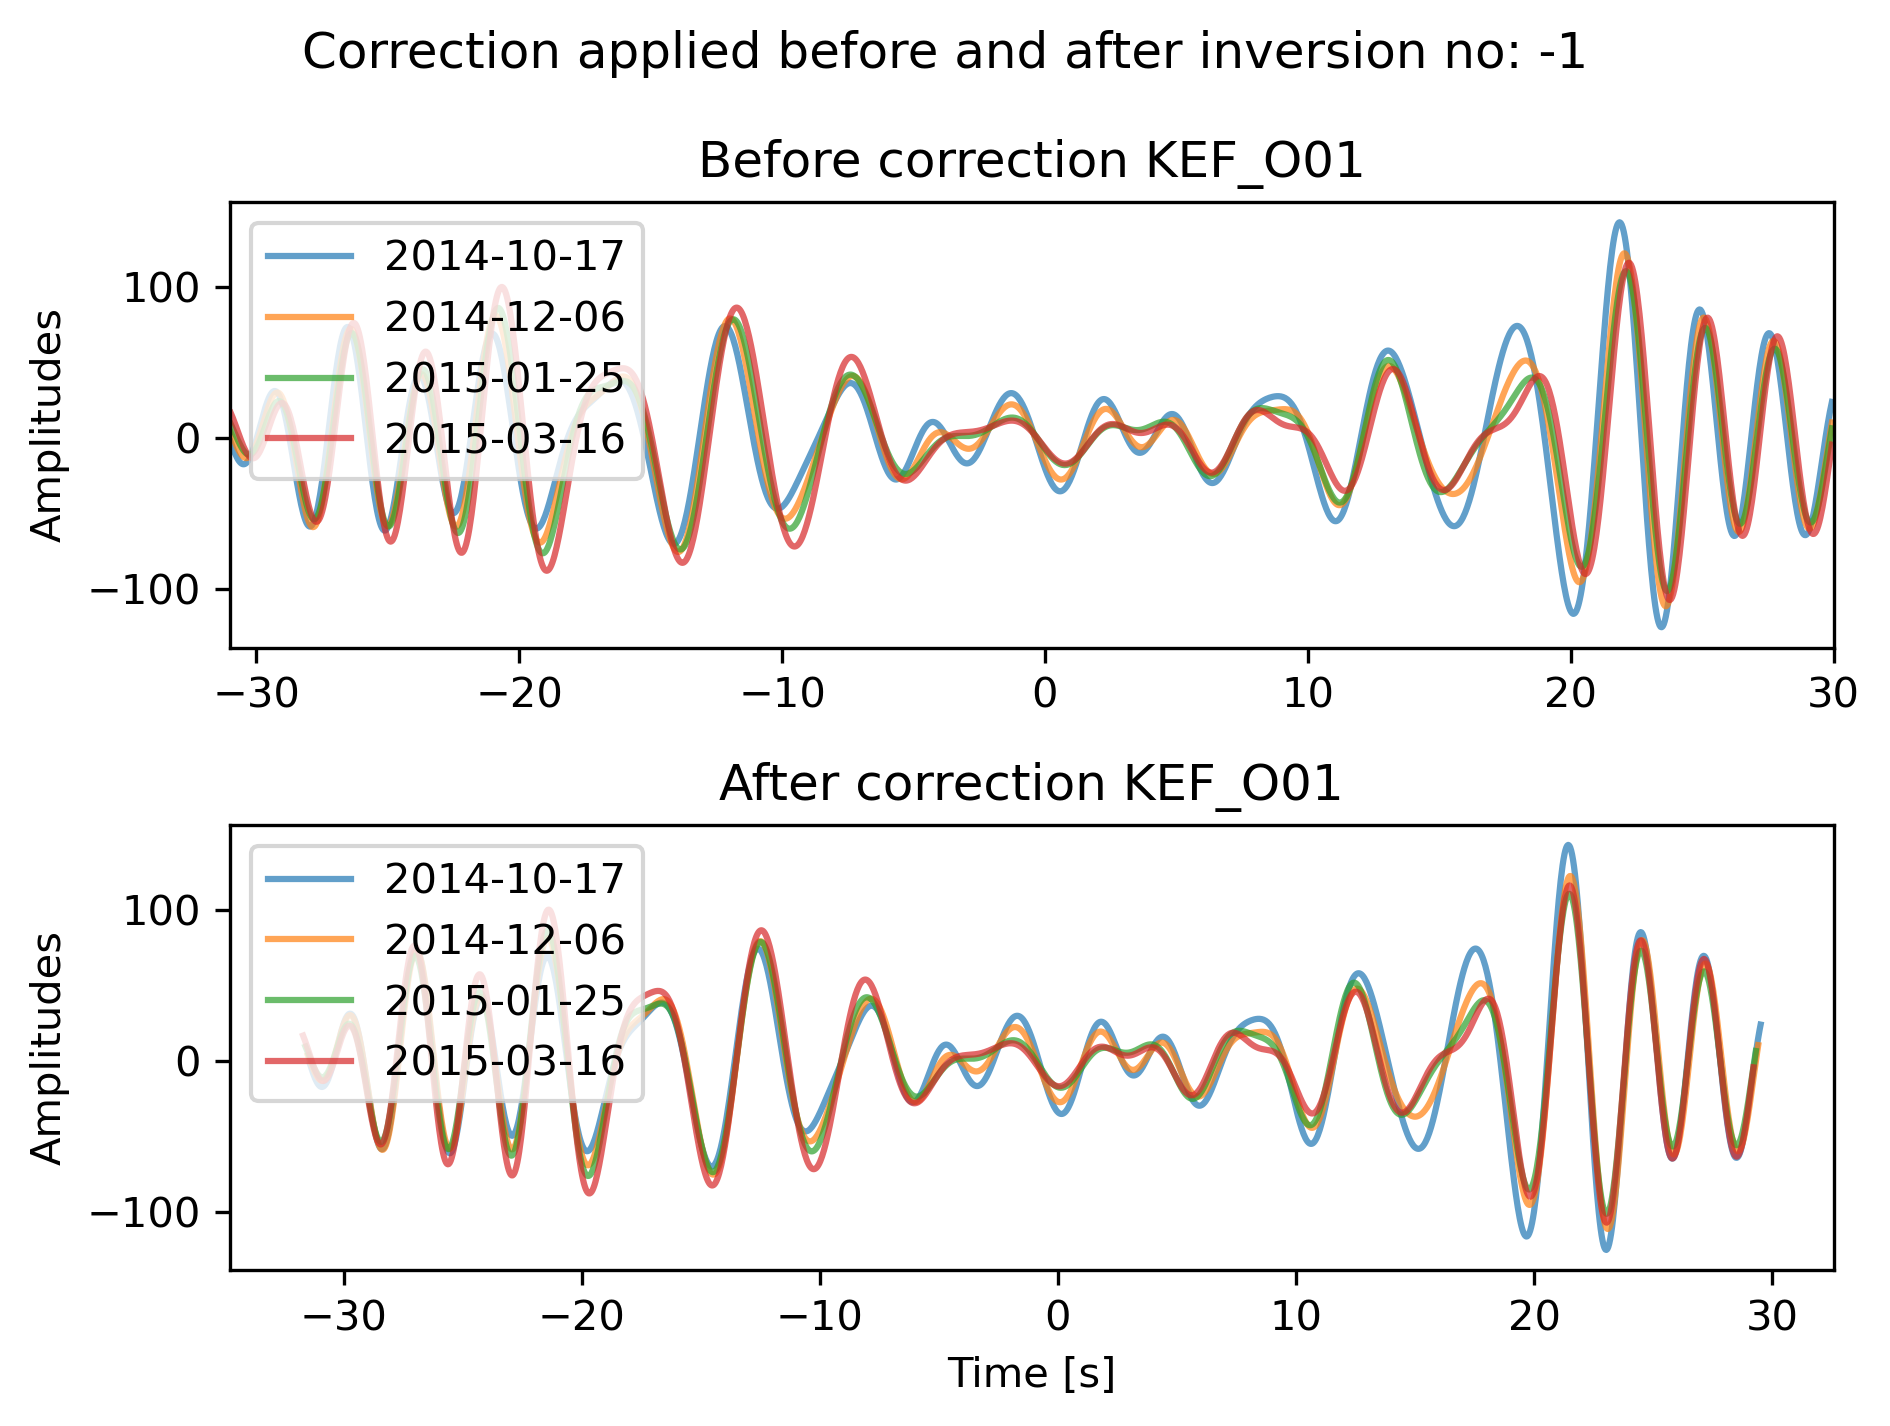

In [8]:
for station in cd.stations:
    if station.code != "O01":
        continue
    print(station.code, station.a[-1], station.b[-1])
    cd.plot_correlation_beforeNafter_correction(station.code, "KEF",min_t=-31, max_t=30)
    break

correlations = []
  

If we want to compare our recovered values with skew values from the stations metadata it is very important to have clear protocols. The metadata contains different dates that are important. For example, the time when the gps was sync, the start of the recording time, the deployment time, the recovery time, the gps sync time, etc. For this reason it is very important to know which dates you are comparing so that you do not mix terms.

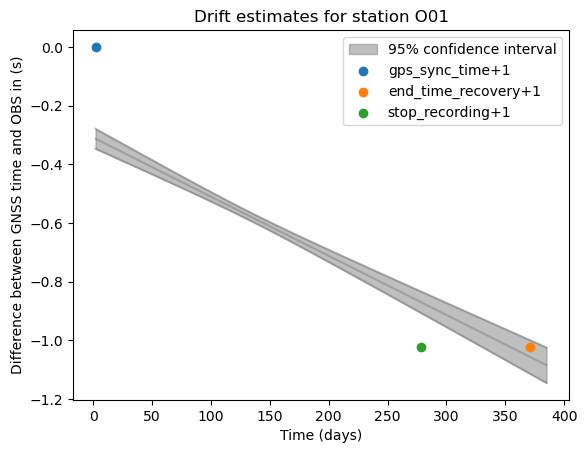

Corrections:
2014-10-17T12:15:38.000000Z
Shift based on OCloC 0.425035538553
Shift based on skew 0.164404919658
Station 1:  O01
Clock drift based on OCloC -0.00201298392081
Clock drift based on skew -0.0027718892091
Corrections:
2014-12-06T12:23:49.000000Z
Shift based on OCloC 0.52569617412
Shift based on skew 0.3030151324
Station 1:  O01
Clock drift based on OCloC -0.00201298392081
Clock drift based on skew -0.0027718892091
Corrections:
2015-01-25T12:12:58.000000Z
Shift based on OCloC 0.626330202886
Shift based on skew 0.441588707439
Station 1:  O01
Clock drift based on OCloC -0.00201298392081
Clock drift based on skew -0.0027718892091
Corrections:
2015-03-16T12:36:48.000000Z
Shift based on OCloC 0.727012715674
Shift based on skew 0.580229045227
Station 1:  O01
Clock drift based on OCloC -0.00201298392081
Clock drift based on skew -0.0027718892091


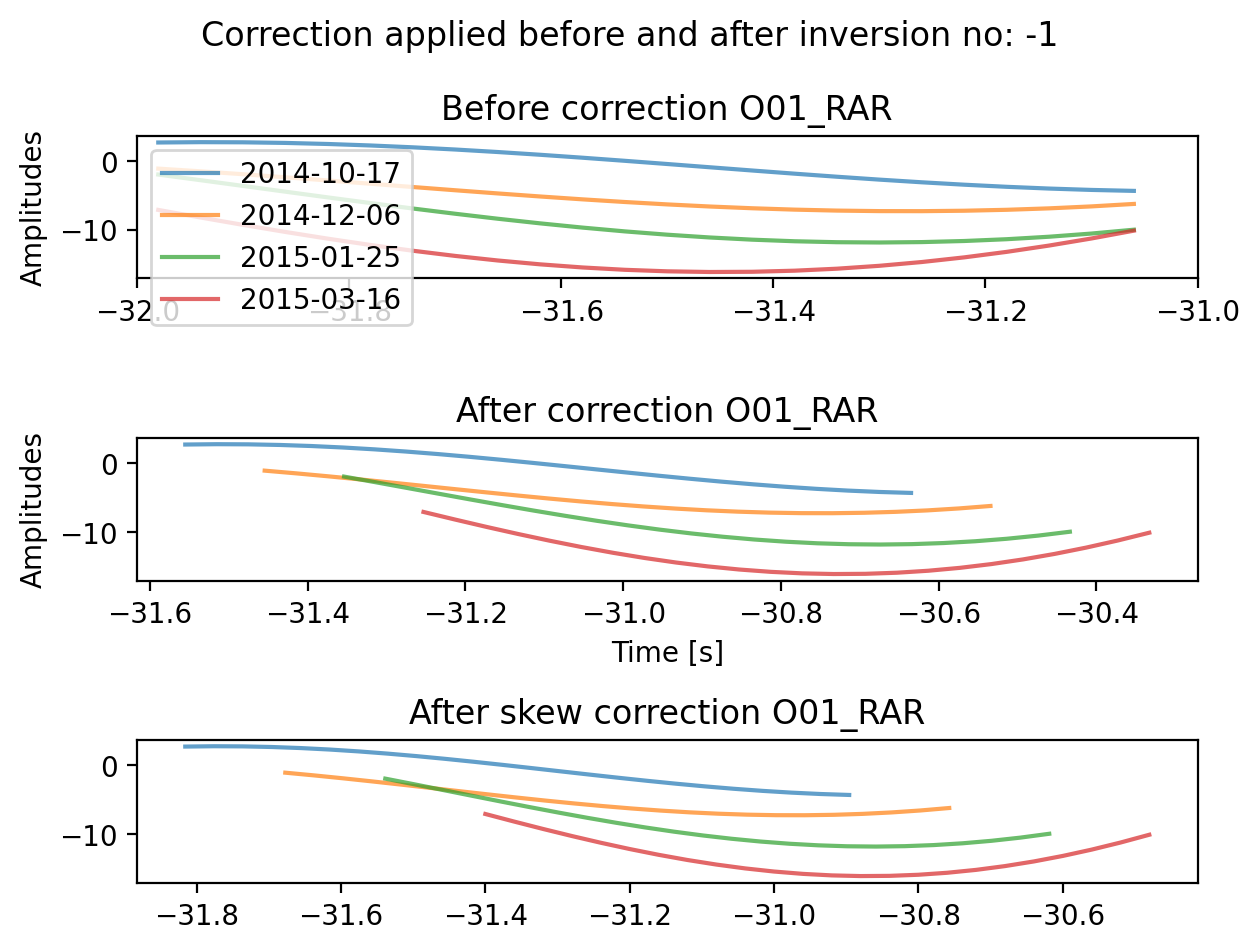

In [4]:
def add_start_end_times_to_stations(cd, filename):
    # Read the csv file
    df = pd.read_csv(filename)

    # Iterate over each row of the DataFrame
    for idx, row in df.iterrows():
        # Find the station with the same sensor code
        try:
            station = cd.get_station(row['sensor_code'])
        except:
            print(f"Station {row['sensor_code']} not found")
            continue

        if station is not None:
            # List of all time-related fields
            time_fields = [
                'gps_sync_time',
                'start_time_gps',
                'st_date',
                'rt_date',
                'deployment_time',
                'end_time_recovery',
                'stop_recording',
                'skew'
            ]

            # Iterate over all time-related fields
            for time_field in time_fields:
                if row[time_field] is not np.nan:
                    try:
                        setattr(station, time_field, obspy.UTCDateTime(row[time_field]))
                    except ValueError:
                        print(f"Could not convert {time_field} for Station {row['sensor_code']}")

            # Add skew value if it's not NaN
            if row['skew'] is not np.nan:
                station.skew_value = row['skew']


def plot_drift_estimates(cd, station_code, savefig=False):

    station = cd.get_station(station_code)
    # plt.figure(dpi=200)
    if station is not None:
        # Generate list
        end_time = obspy.UTCDateTime("2015-09-10")
        start_time = obspy.UTCDateTime("2014-08-22T19:13:46")
        utc_times = [obspy.UTCDateTime(x) for x in np.linspace(
            start_time.timestamp, end_time.timestamp, 100)]
        for boots_a, boots_b in zip(station.bootstrap_a, station.bootstrap_b):
            drifts = [boots_a * (time - cd.reference_time) / 86400 + boots_b for time in utc_times]
            t = [(x - cd.reference_time) / 86400 for x in utc_times]
            drifts = np.array(drifts)
            # plt.scatter(t, drifts, color='grey', alpha=0.5)
        upper_limit, lower_limit, mean_vals = [], [], []
        for time in utc_times:
            drift, drift_std, _95_confidence_interval = calculate_drift_value(
                cd, station_code, time, station.bootstrap_a, station.bootstrap_b)
            upper_limit.append(drift + 2 * drift_std)
            lower_limit.append(drift - 2 * drift_std)
            mean_vals.append(drift)
        plt.fill_between(t, upper_limit, lower_limit, color='grey', alpha=0.5,
                         label='95% confidence interval')
        plt.plot(t, upper_limit, color='grey', alpha=0.5)
        plt.plot(t, lower_limit, color='grey', alpha=0.5)
        plt.plot(t, mean_vals, color='grey', alpha=0.5)

                
        # List of all time-related fields
        time_fields = [
            'gps_sync_time',
            # 'start_time_gps',
            # 'st_date',
            # 'rt_date',
            # 'deployment_time',
            'end_time_recovery',
            'stop_recording',
        ]

        # Iterate over all time-related fields
        for time_field in time_fields:
            # Check if the time field exists for the station and is not None
            time_value = getattr(station, time_field, None)
            if time_value is not None:
                drift, _, _ = calculate_drift_value(
                    cd, station_code, time_value, station.bootstrap_a, station.bootstrap_b)
                skew_value = -np.abs(station.skew_value) / 1e6+1
                if "start" in time_field or "gps_sync" in time_field:
                    skew_value = 0
                plt.scatter((time_value - cd.reference_time) / 86400,
                            skew_value, label=f'{time_field}+1')
                
        plt.xlabel("Time (days)")
        plt.ylabel("Difference between GNSS time and OBS in (s)")
        plt.title(f"Drift estimates for station {station_code}")
        plt.legend()
        if savefig:
            plt.savefig(savefig)
        plt.show()


def calculate_drift_based_on_skew(cd, station_code):
    #a⋅x+b⋅y = c
    #d⋅x+e⋅y = f
    leap_second = 1
    station = cd.get_station(station_code)
    a = (cd.reference_time - station.gps_sync_time) / 86400.0
    b = 1
    c = 0
    d = (cd.reference_time - station.end_time_recovery) / 86400.0
    e = 1
    f = (station.skew_value / 1e6) - leap_second
    # Represent the coefficients as matrices
    A = np.array([[a, 1], 
                  [d, 1]])
    B = np.array([c, f])
    # Solve the system of equations

    skew_drift, skew_dt_at_reference_time = np.linalg.solve(A, B)
    station.skew_drift = skew_drift
    station.skew_dt_at_reference_time = skew_dt_at_reference_time


def plot_correlation_beforeNafter_correction(
        self, station1_code, station2_code, iteration=-1, min_t=-50, max_t=30
    ):
        """
        Parameters
        ----------
        station1_code: TYPE
            DESCRIPTION.
        station2_code: TYPE
            DESCRIPTION.
        iteration: TYPE, optional
            DESCRIPTION. The default is -1.
        min_t: TYPE, optional
            DESCRIPTION. The default is -50.
        max_t: TYPE, optional
            DESCRIPTION. The default is 30.

        Returns
        -------
        None.

        """
        from ocloc import read_correlation_file, trim_correlation_trace
        from ocloc import correlations_with_parameters
        correlation_list = self.get_correlations_of_stationpair(
            station1_code, station2_code
        )
        station1 = self.get_station(correlation_list[0].station1_code)
        station2 = self.get_station(correlation_list[0].station2_code)
        
        if not station1.needs_correction:
            if not station2.needs_correction:
                raise Exception("Neither station needs correction.")

            if len(station2.a) == 0:
                raise Exception(
                    station2.code + " station has no correction yet."
                )
        elif len(station1.a) == 0:
            raise Exception(station1.code + " station has no correction yet.")
        ref_t = self.reference_time

        # As some traces were processed differently we will separate the plots
        # into the groups of traces that share the same processing parameters.
        for params in self.processing_parameters:
            correlations = correlations_with_parameters(
                correlation_list, params
            )

            f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, dpi=200)

            for correlation in correlations:
                average_date = correlation.average_date
                t_N_lps = (average_date - ref_t) / 86400.0
                if station1.needs_correction:
                    correction_sta1 = -(
                        station1.a[iteration] * t_N_lps + station1.b[iteration]
                    )
                    calculate_drift_based_on_skew(self, station1.code)
                    skew_correction_sta1 = -(station1.skew_drift * t_N_lps
                                             + station1.skew_dt_at_reference_time)
                else:
                    correction_sta1 = 0
                    skew_correction_sta1 = 0
                if station2.needs_correction:
                    correction_sta2 = (
                        station2.a[iteration] * t_N_lps + station2.b[iteration]
                    )
                    calculate_drift_based_on_skew(self, station2.code)
                    skew_sta2 = station2.skew_drift * t_N_lps + station2.skew_dt_at_reference_time

                else:
                    correction_sta2 = 0
                    skew_sta2 = 0
                    
                shift = correction_sta1 + correction_sta2
                shift_skew = skew_correction_sta1 + skew_sta2
                freqmin = correlation.processing_parameters.freqmin
                freqmax = correlation.processing_parameters.freqmax
                tr = read_correlation_file(correlation.file_path)
                t1, data = trim_correlation_trace(
                    tr, min_t, max_t, freqmin, freqmax
                )
                ax1.plot(
                    t1, data, label=str(tr.stats.average_date)[:10], alpha=0.7
                )
                ax2.plot(
                    t1 + shift,
                    data,
                    label=str(tr.stats.average_date)[:10],
                    alpha=0.7,
                )
                ax3.plot(
                    t1 + shift_skew,
                    data,
                    label=str(tr.stats.average_date)[:10],
                    alpha=0.7,
                )
                print("Corrections:")
                print(average_date)
                print("Shift based on OCloC", shift)
                print("Shift based on skew", shift_skew)
                if station1.needs_correction:
                    print("Station 1: ", station1.code)
                    print("Clock drift based on OCloC", station1.a[iteration])
                    print("Clock drift based on skew", station1.skew_drift)
                if station2.needs_correction:
                    print("Station 2: ", station2.code)
                    print("Clock drift based on OCloC", station2.a[iteration])
                    print("Clock drift based on skew", station2.skew_drift)
                    


            f.suptitle(
                "Correction applied before and after inversion no: "
                + str(iteration)
            )
            ax1.set_title("Before correction " + tr.stats.station_pair)
            ax2.set_title("After correction " + tr.stats.station_pair)
            ax3.set_title("After skew correction " + tr.stats.station_pair)
            ax2.set_xlabel("Time [s]")
            ax2.set_ylabel("Amplitudes")
            ax1.set_ylabel("Amplitudes")
            ax1.set_xlim(min_t, max_t)
            ax1.legend(loc=2)
            # ax2.legend(loc=2)
            plt.tight_layout()
            plt.show()
        

add_start_end_times_to_stations(
    cd,
    'metadata/iceland_metadata_extended.csv')
for station in cd.stations:
    if not station.needs_correction:
        continue
    plot_drift_estimates(cd, station.code)

    plot_correlation_beforeNafter_correction(
            cd, station.code, "RAR", iteration=-1, min_t=-32, max_t=-31
        )
    break
    
    

In [ ]:
add_start_end_times_to_stations(
    cd,
    '/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/skew_values_corrected.csv')

df = create_drift_table(cd)
display(df)

KeyError: 'sensor_code'

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


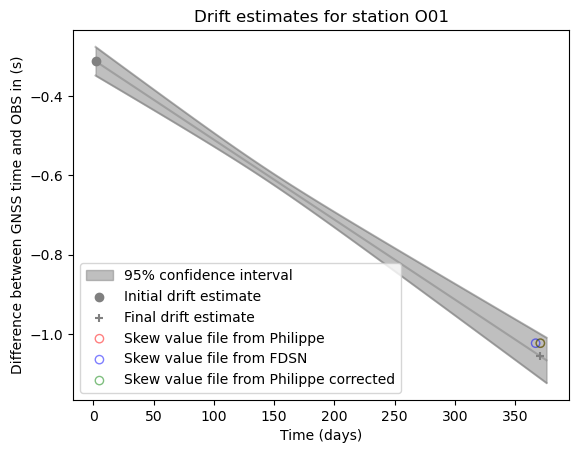

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


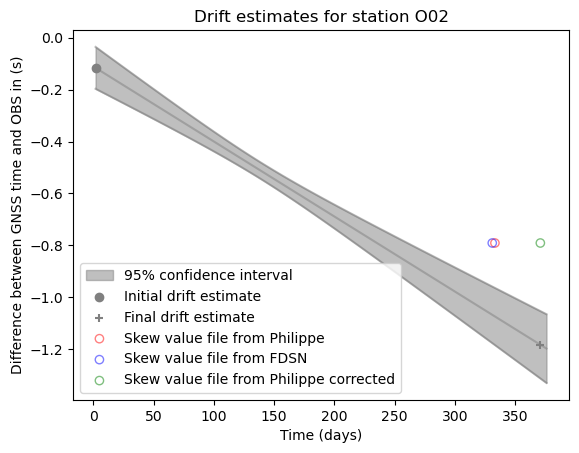

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


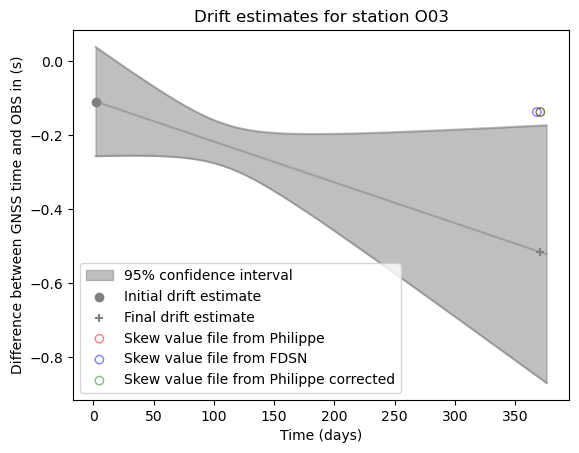

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


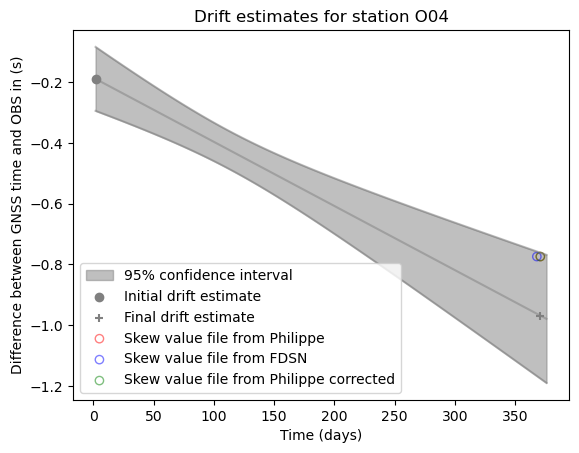

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


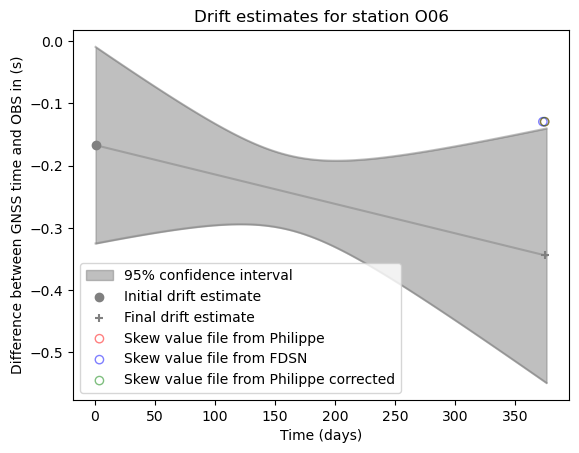

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


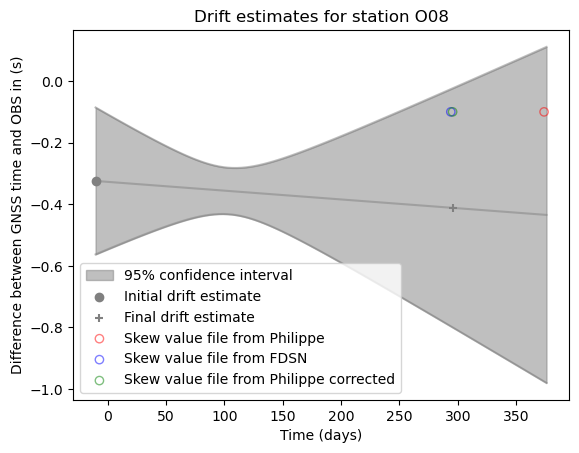

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


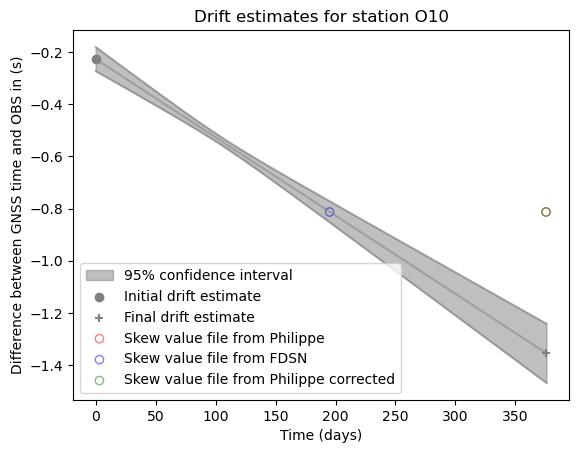

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


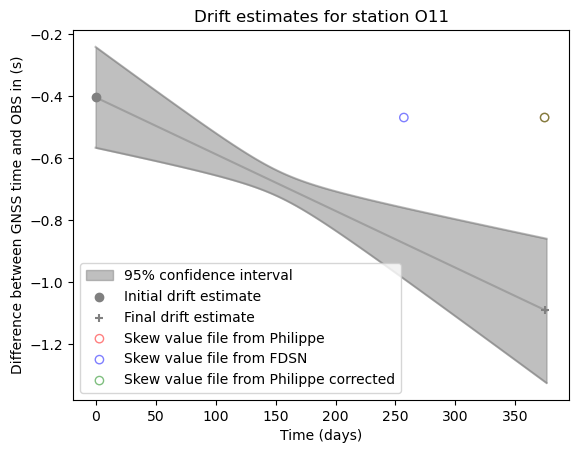

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


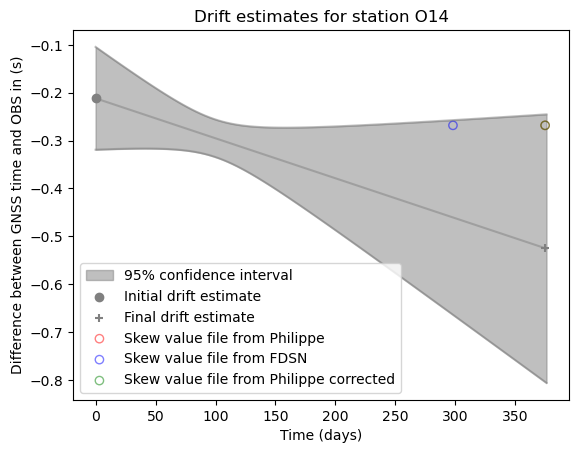

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


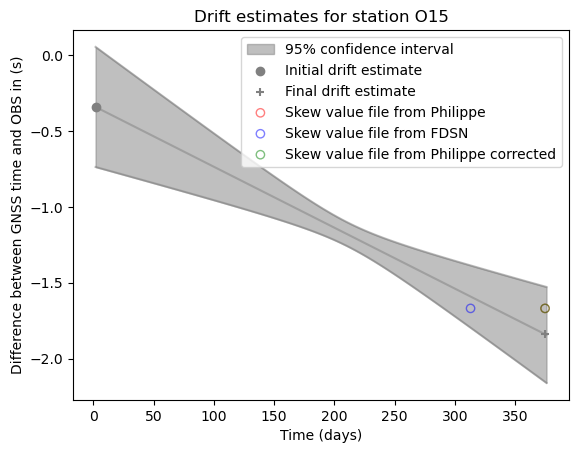

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


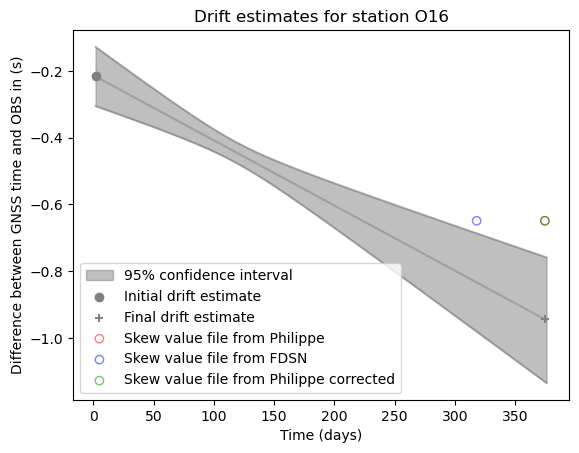

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


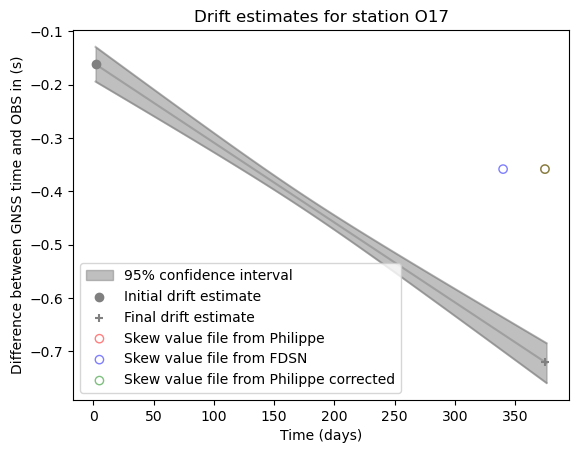

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


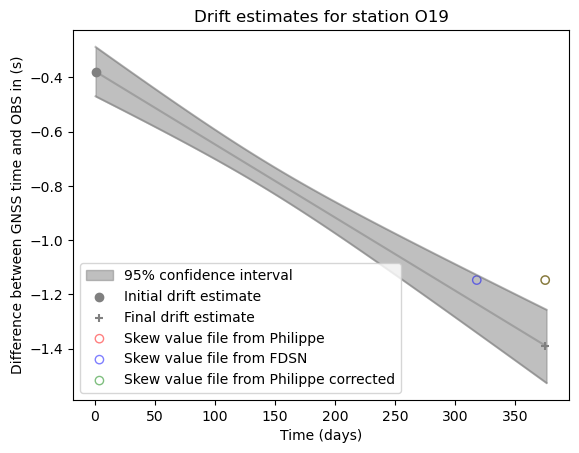

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


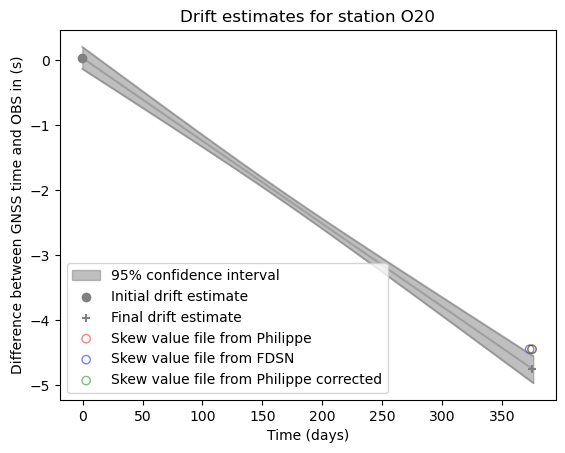

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


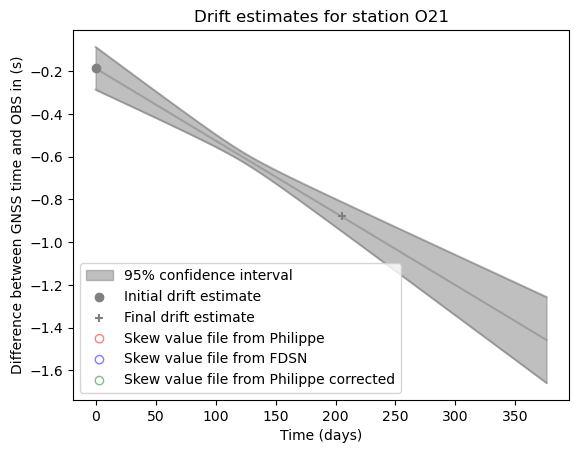

Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found
Station O05 not found
Station O07 not found
Station O12 not found
Station O18 not found


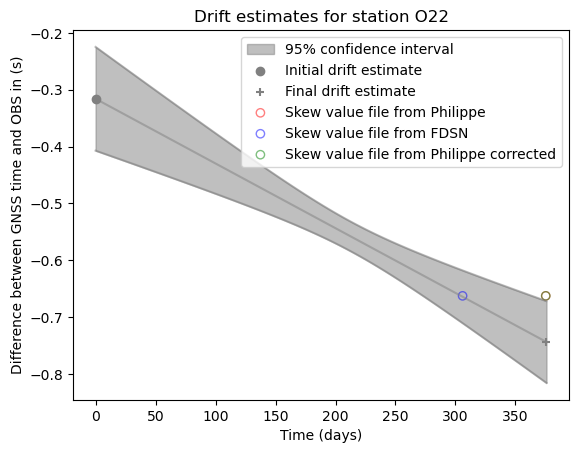

UnboundLocalError: local variable 't' referenced before assignment

In [ ]:
for station in cd.stations:
    if station.needs_correction == False:
        continue
    # if station.code != 'O02':
    #     continue
    plot_drift_estimates(cd, station.code)
    